In [1]:
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from sklearn import linear_model
from sklearn.metrics import RocCurveDisplay, auc, mean_squared_error, roc_curve
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.utils.fixes import loguniform

from label_flip_revised.utils import create_dir


In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
print(PATH_ROOT)

/home/lukec/workspace/diva_01


In [3]:
path_output = os.path.join(PATH_ROOT, 'results_plot')
print(path_output)
create_dir(path_output)

/home/lukec/workspace/diva_01/results_plot


In [4]:
df = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'synth', 'synth_falfa_nn_db.csv'))
print(df.shape)

(1350, 38)


In [5]:
DIF_LEVELS = ['Hard', 'Normal', 'Easy']

df['Difficulty'] = df['Data.Base'].apply(lambda x: x.split('_')[0])
cat_type = CategoricalDtype(categories=DIF_LEVELS, ordered=True)
df['Difficulty'] = df['Difficulty'].astype(cat_type)

In [6]:
print(df.columns)

Index(['Data', 'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
       'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
       'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
       'Path.Train', 'Path.Poison', 'Path.Test', 'Rate', 'Train.Clean',
       'Test.Clean', 'Train.Poison', 'Test.Poison', 'Data.Base', 'Difficulty'],
      dtype='object')


In [7]:
COLS_CM = [
    'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
    'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
    'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
]
COL_Y = 'Test.Poison'

print(len(df))

1350


In [8]:
ATTACKS = ['falfa_nn', 'alfa_svm', 'rand_svm', 'poison_svm']

In [9]:
N_ITER_SEARCH = 100

In [10]:
# Find parameter
param = {'alpha': loguniform(1e-4, 10),}
X = df[COLS_CM]
y = df[COL_Y]
regressor = linear_model.Ridge()
param_search = RandomizedSearchCV(regressor, param_distributions=param, n_iter=N_ITER_SEARCH, n_jobs=-1)
param_search.fit(X, y)

best_estimator_ = param_search.best_estimator_.get_params()
alpha = np.round(best_estimator_['alpha'], 4)
print(alpha)

0.0001


In [11]:
N_FOLD = 5

df['Prediction'] = 0.

# Split by clean data
idx_clean = df[df['Rate'] == 0].index
kf = KFold(n_splits=N_FOLD, shuffle=True)
for i_train, i_test in kf.split(idx_clean):
    idx_train_clean = idx_clean[i_train]
    idx_test_clean = idx_clean[i_test]

    data_train = df.loc[idx_train_clean, 'Data.Base']
    data_test = df.loc[idx_test_clean, 'Data.Base']

    idx_train = df[df['Data.Base'].isin(data_train)].index
    idx_test = df[df['Data.Base'].isin(data_test)].index
    assert len(idx_train) + len(idx_test) == df.shape[0], f'{len(idx_train)} + {len(idx_test)} != {df.shape[0]}'

    X_train = df.loc[idx_train, COLS_CM]
    y_train = df.loc[idx_train, COL_Y]
    X_test = df.loc[idx_test, COLS_CM]
    y_test = df.loc[idx_test, COL_Y]

    regressor = linear_model.Ridge(alpha=alpha)
    regressor.fit(X_train, y_train)

    df.loc[idx_test, 'Prediction'] = regressor.predict(X_test)

# Apply clipping
df['Prediction'] = np.amin([df['Prediction'].to_numpy(), np.ones(df.shape[0])], axis=0)

In [12]:
df.to_csv(os.path.join(path_output, 'synth_01_pred.csv'), index=False)

In [13]:
rmse = np.sqrt(mean_squared_error(df['Test.Poison'].to_numpy(), df['Prediction'].to_numpy()))
print('RMSE test: {:.3f}'.format(rmse))

RMSE test: 0.064


In [21]:
FONTSIZE = 14
FIGSIZE = (4, 4)
COLORS = {
    'Hard': '#d32f2f',
    'Normal': '#1976d2',
    'Easy': '#388e3c',
    'Overall': '#000000'
}
THRESHOLD = 0.05

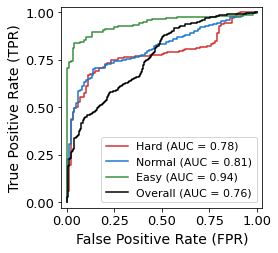

In [22]:
plt.rcParams["font.size"] = FONTSIZE
fig, ax = plt.subplots(figsize=FIGSIZE)
plt.gca().set_aspect('equal')  # Fix to square

for dif in DIF_LEVELS:
    df_ = df[df['Difficulty'] == dif]
    y_true_ = (df_['Rate'].to_numpy() > THRESHOLD).astype(int)
    y_score_ = df_['Train.Poison'] - df_['Prediction']
    fpr_, tpr_, _ = roc_curve(y_true_, y_score_)

    data_ = {
        'fpr': fpr_,
        'tpr': tpr_,
    }
    df_res = pd.DataFrame(data_)
    df_res.to_csv(os.path.join(path_output, f'synth_roc_{dif}.csv'), index=False)

    roc_auc_ = auc(fpr_, tpr_)
    roc_display = RocCurveDisplay(fpr=fpr_, tpr=tpr_, roc_auc=roc_auc_).plot(ax=ax, name=dif, c=COLORS[dif])

# Draw all difficulties
y_true_ = (df['Rate'].to_numpy() > THRESHOLD).astype(int)
y_score_ = df['Train.Poison'] - df['Prediction']
fpr_, tpr_, _ = roc_curve(y_true_, y_score_)

data_ = {
    'fpr': fpr_,
    'tpr': tpr_,
}
df_res = pd.DataFrame(data_)
df_res.to_csv(os.path.join(path_output, f'synth_roc_all.csv'), index=False)

roc_auc_ = auc(fpr_, tpr_)
roc_display = RocCurveDisplay(fpr=fpr_, tpr=tpr_, roc_auc=roc_auc_).plot(ax=ax, name='Overall', c=COLORS['Overall'])

ax.set_title('')

plt.legend(fontsize=FONTSIZE-3, loc='lower right')
plt.xticks(np.linspace(0, 1, num=5), fontsize=FONTSIZE-1)
plt.yticks(np.linspace(0, 1, num=5), fontsize=FONTSIZE-1)
plt.xlabel('False Positive Rate (FPR)', fontsize=FONTSIZE)
plt.ylabel('True Positive Rate (TPR)', fontsize=FONTSIZE)
plt.xlim(-0.03, 1.03)
plt.ylim(-0.03, 1.03)
plt.tight_layout()
# path_output = os.path.join(path_output, 'roc_synth.pdf')
# plt.savefig(path_output, dpi=300)
plt.show()